In [1]:
import json
import graphviz 
from collections import Counter
import numpy as np
import pandas as pd

from os import system
from IPython.display import Image

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
loans = pd.read_csv('lending-club-data.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

print (loans['safe_loans'].value_counts())

 1    99457
-1    23150
Name: safe_loans, dtype: int64


In [4]:
print ("percentage of safe loans :", len(loans[loans['safe_loans']==+1]) / len(loans['safe_loans']))
print ("percentage of risky loans :", len(loans[loans['safe_loans']==-1]) / len(loans['safe_loans']))

percentage of safe loans : 0.8111853319957262
percentage of risky loans : 0.18881466800427382


In [5]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [6]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

print ("Number of safe loans  : %s" % len(safe_loans_raw))
print ("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


In [7]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(n=len(risky_loans_raw), random_state=1)

print("len risky_loans = {}, len safe_loans = {}".format(len(risky_loans), len(safe_loans)))

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

len risky_loans = 23150, len safe_loans = 23150


Now we can verify that loans_data is comprised of approximately 50% safe loans and 50% risky loans.

In [8]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)
        
for feature in categorical_variables:
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]
    
#print (loans.head(2))        
#print (loans.columns)

In [9]:
with open('module-5-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-5-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

Build a decision tree classifier and make predictions :

In [10]:
train_Y = train_data['safe_loans'].values
train_X = train_data.drop('safe_loans', axis=1).values

decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(train_X, train_Y)

small_model = DecisionTreeClassifier(max_depth=2)
small_model = small_model.fit(train_X, train_Y)

In [11]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)

sample_validation_data_Y = sample_validation_data['safe_loans'].values
sample_validation_data_X = sample_validation_data.drop('safe_loans', axis=1).values

predicted_safe_loan = decision_tree_model.predict(sample_validation_data_X)

print("predictions :", predicted_safe_loan)
print("Actal value :", sample_validation_data_Y)
print("percentage of the correct predictions on sample_validation_data is", Counter(predicted_safe_loan == sample_validation_data_Y)[True]/len(sample_validation_data_Y))

predictions : [ 1 -1 -1  1]
Actal value : [ 1  1 -1 -1]
percentage of the correct predictions on sample_validation_data is 0.5


Explore probability predictions :

In [12]:
max_prob_index = 0 
loop_index = 0
max_prob = 0 
for i in decision_tree_model.predict_proba(sample_validation_data_X):
    loop_index +=1
    if i[1] > max_prob:
        max_prob = i[1]
        max_prob_index = loop_index
        
print("The loan which has the highest probability of being classified as a safe loan is number", max_prob_index)

The loan which has the highest probability of being classified as a safe loan is number 4


In [13]:
small_model.predict_proba(sample_validation_data_X)

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

The probability predictions are the exact same for the 2nd and 3rd loans, Because the elements of these two loans which the tree will considering them to decide, are exactly same in these two loan.

Visualize the prediction on a tree :

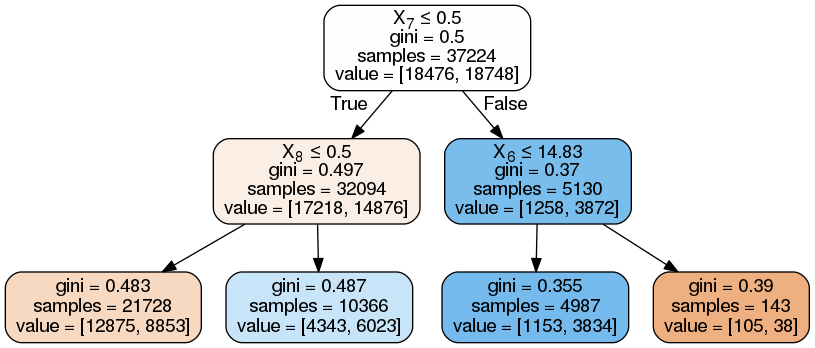

In [14]:
dot_data = tree.export_graphviz(small_model, out_file='simple_tree.dot',
                                filled=True, rounded=True,
                                special_characters=True)

system("dot -Tpng simple_tree.dot -o simple_tree.png")

Image(filename='simple_tree.png')

Evaluating accuracy of the decision tree model :

In [15]:
print("Small model accuracy on train set :", small_model.score(train_X, train_Y))
print("Decision tree model accuracy on train set :", decision_tree_model.score(train_X, train_Y))

Small model accuracy on train set : 0.6135020416935311
Decision tree model accuracy on train set : 0.6405276165914464


In [16]:
validation_Y = validation_data['safe_loans'].values
validation_X = validation_data.drop('safe_loans', axis=1).values

print("Small model accuracy on validation set :", small_model.score(validation_X, validation_Y))
print("Decision tree model accuracy on validation set :", decision_tree_model.score(validation_X, validation_Y))

Small model accuracy on validation set : 0.6193451098664369
Decision tree model accuracy on validation set : 0.6361482119775959


Evaluating accuracy of a complex decision tree model :

In [17]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model = big_model.fit(train_X, train_Y)

print("Decision tree model accuracy on validation set :", decision_tree_model.score(validation_X, validation_Y))
print("Big model accuracy on validation set :", big_model.score(validation_X, validation_Y))

Decision tree model accuracy on validation set : 0.6361482119775959
Big model accuracy on validation set : 0.6263464024127531


The performance of big_model on the validation set compare to decision_tree_model on the validation set increased, so taht would be a sign of overfitting.

Quantifying the cost of mistakes :

In [18]:
predictions = decision_tree_model.predict(validation_X)

false_positives = ((predictions==1) * (validation_Y==-1)).sum()
false_negatives = ((predictions==-1) * (validation_Y==1)).sum()

print("The total cost of mistakes made by decision_tree_model on validation_data would be :", 10000 * false_negatives + 20000 * false_positives)

The total cost of mistakes made by decision_tree_model on validation_data would be : 50390000
